In [36]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris


# Import PySwarms
import pyswarms as ps

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
n_inputs = 30
n_hidden = 60
n_classes = 2

num_samples = 426

index = 0
fitness = []
indexes = []

In [38]:
def logits_function(p, X, y):
    # Roll-back the weights and biases
    W1 = p[0:1800].reshape((n_inputs,n_hidden))
    b1 = p[1800:1860].reshape((n_hidden,))
    W2 = p[1860:1980].reshape((n_hidden,n_classes))
    b2 = p[1980:1982].reshape((n_classes,))

    # Perform forward propagation
    z1 = X.dot(W1) + b1  # Pre-activation in Layer 1
    a1 = np.tanh(z1)     # Activation in Layer 1
    logits = a1.dot(W2) + b2 # Pre-activation in Layer 2

    if y is not None and (len(indexes) == 0 or index != indexes[len(fitness)-1]):
        y_pred = np.argmax(logits, axis=1)
        score = (y_pred == y).sum() / y.shape[0]

        if  len(fitness) == 0 or score > fitness[len(fitness)-1] :
            fitness.append(score)
            indexes.append(index)

    return logits          # Logits for Layer 2

In [39]:
# Forward propagation
def forward_prop(params, X,y):
    logits = logits_function(params, X, y)

    # Compute for the softmax of the logits
    exp_scores = np.exp(logits)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Compute for the negative log likelihood

    corect_logprobs = -np.log(probs[range(num_samples), y])
    loss = np.sum(corect_logprobs) / num_samples

    return loss

In [40]:
def Get_PSO(f):
    # Initialize swarm
    options = {'c1': 2.05, 'c2': 2.05, 'w':0.729}

    # Call instance of PSO
    dimensions = (n_inputs * n_hidden) + (n_hidden * n_classes) + n_hidden + n_classes
    optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=dimensions, options=options)

    # Perform optimization
    cost, pos = optimizer.optimize(f, iters=1000)
    return pos

In [41]:
def predict(pos, X):
    logits = logits_function(pos, X, None)
    y_pred = np.argmax(logits, axis=1)
    return y_pred

In [42]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

labelencoder = LabelEncoder()

def Start_Breast_Cancer():
    data = pd.read_csv('databases/breast-cancer.data', names = ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
                                                                'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
                                                                'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
                                                                'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
                                                                'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
                                                                'fractal_dimension_se', 'radius_worst', 'texture_worst',
                                                                'perimeter_worst', 'area_worst', 'smoothness_worst',
                                                                'compactness_worst', 'concavity_worst', 'concave points_worst',
                                                                'symmetry_worst', 'fractal_dimension_worst'])

    data = data.drop('id',axis=1)

    data['diagnosis'] = data['diagnosis'].map({'M':1,'B':0})

    datas = pd.DataFrame(preprocessing.scale(data.iloc[:,1:31]))
    datas.columns = list(data.iloc[:,1:31].columns)
    target = data['diagnosis']
    data = datas.values

    x_train, x_test, y_train, y_test = train_test_split(data, target)

    def f(x):
        global index
        n_particles = x.shape[0]
        j = [forward_prop(x[i], x_train, y_train) for i in range(n_particles)]
        index += 1
        return np.array(j)

    pos = Get_PSO(f)
    scores = (predict(pos, x_test) == y_test)

    print("\n Breast Cancer \n")
    print("Accuracy: %.2f%%" % (100 * np.mean(scores)))

In [43]:
Start_Breast_Cancer()

print(indexes)
print(fitness)

2022-03-27 02:41:39,923 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 2.05, 'c2': 2.05, 'w': 0.3}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.0229
2022-03-27 02:41:54,356 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.022947365268385218, best pos: [ 1.63750559  1.59051619 -0.50990286 ...  1.21064152  0.69757841
 -0.23233276]



 Breast Cancer 

Accuracy: 98.60%
[0, 1, 2, 3, 4, 5, 6, 10, 23, 34, 42, 59, 71, 72, 82, 95, 96, 420, 429, 455, 592]
[0.11502347417840375, 0.8615023474178404, 0.892018779342723, 0.9061032863849765, 0.9295774647887324, 0.931924882629108, 0.9342723004694836, 0.9460093896713615, 0.9530516431924883, 0.9553990610328639, 0.960093896713615, 0.9671361502347418, 0.9694835680751174, 0.9741784037558685, 0.9765258215962441, 0.9788732394366197, 0.9812206572769953, 0.9835680751173709, 0.9859154929577465, 0.9906103286384976, 0.9929577464788732]


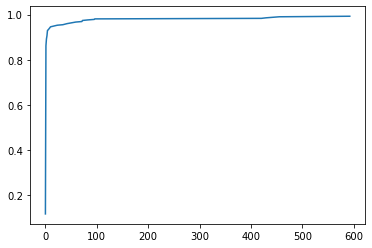

In [44]:
#plot indexes and fitness
plt.plot(indexes, fitness)